In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('bike_rental_hour.csv')

In [15]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


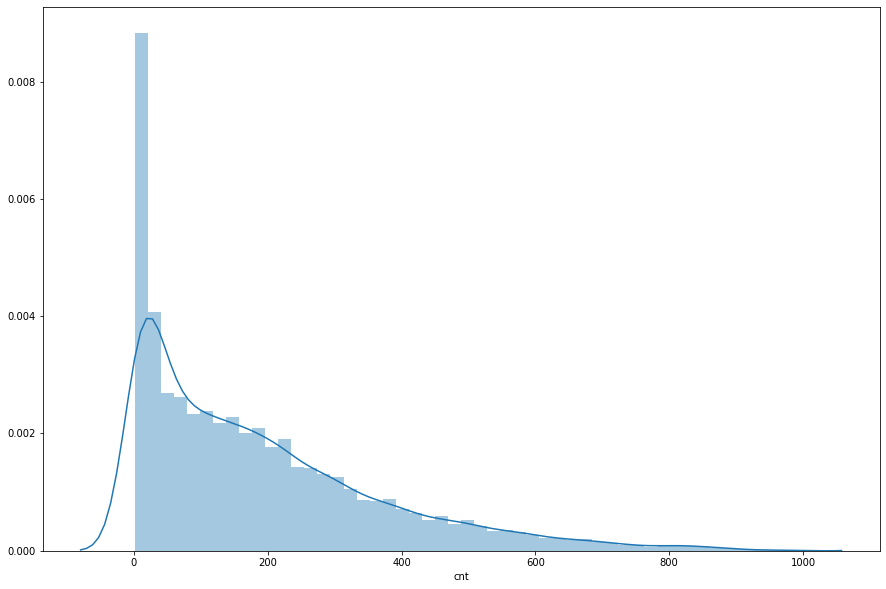

In [17]:
plt.figure(figsize=(15,10))
sns.distplot(df['cnt'])

In [21]:
df.corr()['cnt'].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [22]:
def assign_label(hr):
    if hr < 6:
        return 4
    elif hr < 12:
        return 1
    elif hr < 18:
        return 2
    else:
        return 3

In [24]:
df['time_label'] = df['hr'].apply(assign_label)

In [25]:
train = df.sample(frac=0.8)

In [27]:
test = df.loc[~df.index.isin(train.index)]

In [47]:
features = ['hum', 'weathersit', 'windspeed', 'mnth', 'season', 'yr', 'hr', 'atemp', 'temp', 'time_label']

In [48]:
from sklearn.linear_model import LinearRegression

In [49]:
lr = LinearRegression()

In [50]:
lr.fit(train[features], train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
predictions = lr.predict(test[features])

In [52]:
from sklearn.metrics import mean_squared_error

In [53]:
mse = mean_squared_error(test['cnt'], predictions)

In [54]:
rmse = mse**0.5

In [55]:
print(rmse)

133.63091180643286


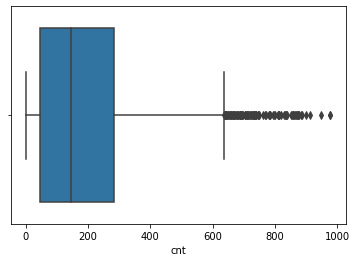

In [62]:
sns.boxplot(test['cnt'])

Given that the range of values in "cnt" goes from 0 to ~1000, an RMSE of 133.6 is a little higher than I would like it to be. 

In [63]:
from sklearn.tree import DecisionTreeRegressor

In [66]:
dtr = DecisionTreeRegressor(min_samples_leaf=10)

In [67]:
dtr.fit(train[features], train['cnt'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [68]:
predictions = dtr.predict(test[features])

In [69]:
mse = mean_squared_error(test['cnt'], predictions)

In [70]:
rmse = mse**0.5

In [71]:
print(rmse)

92.77551138967041


A error improvement of more than ten is not insignificant, so it seems as if our DTR model is superior to our LR model. Let's check for overfitting and play with parameters to see if we can find an even better model.

In [72]:
predictions = dtr.predict(train[features])

In [73]:
mse = mean_squared_error(train['cnt'], predictions)

In [74]:
rmse = mse**0.5

In [75]:
print(rmse)

73.103112185373


Even though we found a better model, the fact that there is such a significant difference in the error found using the training data vs. the test data means we have some overfitting. What happens if we increase the minimum samples needed to make a leaf?

In [88]:
dtr = DecisionTreeRegressor(min_samples_leaf=20)
dtr.fit(train[features], train['cnt'])
predictions = dtr.predict(test[features])
mse = mean_squared_error(test['cnt'], predictions)
rmse = mse**0.5
print(rmse)

90.27294505208636


In [89]:
predictions = dtr.predict(train[features])
mse = mean_squared_error(train['cnt'], predictions)
rmse = mse**0.5
print(rmse)

80.44368810300895


Now we have a more generalizable fit, and we've found a lower error on our test data. But what about using a Random Forest Regression Model?

In [90]:
from sklearn.ensemble import RandomForestRegressor

In [99]:
rfr = RandomForestRegressor(min_samples_leaf=22)

In [100]:
rfr.fit(train[features], train['cnt'])
predictions = rfr.predict(test[features])
mse = mean_squared_error(test['cnt'], predictions)
rmse = mse**0.5
print(rmse)

/home/annahcasey/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


87.65882654674986


In [98]:
predictions = rfr.predict(train[features])
mse = mean_squared_error(train['cnt'], predictions)
rmse = mse**0.5
print(rmse)

81.35400372564048


Here we find our best model yet. 